In [1]:
# https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np

In [ ]:
#---------------#
# Load the data #
#---------------#

In [3]:
# message Person {
#  required string name = 1;
#  required int32 id = 2;
#  optional string email = 3;
# enum PhoneType {
#  MOBILE = 0;
#  HOME = 1;
#  WORK = 2;
#  }
# message PhoneNumber {
#  required string number = 1;
#  optional PhoneType type = 2 [default = HOME];
#  }
# repeated PhoneNumber phone = 4;
# }

SyntaxError: invalid syntax (<ipython-input-3-361b49bc1b6d>, line 1)

In [4]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [5]:
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [11]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [12]:
print(_bytes_feature(b'some string'))
print(_float_feature(0.5))
print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "some string"
}

float_list {
  value: 0.5
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



In [15]:
a = np.random.randn(2, 2)

_bytes_feature(tf.io.serialize_tensor(a))

bytes_list {
  value: "\010\002\022\010\022\002\010\002\022\002\010\002\" \223\304\027:C\325\347\277\004H\211\305\331\333\364?\241\323~\221\013\235\221\277\r\263H\316\375\337\002\300"
}

In [16]:
# ----------------------------------------- #
# Create tf.train.Example message from data #
# ----------------------------------------- #

In [18]:
# 1) create tf.train.Feature using shortcut function
# 2) create a dictionary:
#     feature = {
#      ‘feature0’: _int64_feature(feature0),
#      ‘feature1’: _int64_feature(feature1),
#      ‘feature2’: _bytes_feature(feature2),
#      ‘feature3’: _float_feature(feature3),
#      }

# 3) Create tf.train.Example:
#     example_proto = tf.train.Example(features = tf.train.Features(feature=feature))

In [30]:
import numpy as np

# The number of observations in the dataset.
n_observations = 1000

# Boolean feaure, encoded as False or True
feature0 = np.random.choice([False, True], n_observations)

# Float feature
feature1 = np.random.randn(n_observations)

# String feature
strings = np.array([b'cat', b'dog'])
feature2 = np.random.choice(strings, n_observations)

# Non-scalar FLoat feature, 2x2 matrices sampled from a standard normal distribution
feature3 = np.random.randn(n_observations, 2, 2)

dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))

In [31]:
dataset

<TensorSliceDataset shapes: ((), (), (), (2, 2)), types: (tf.bool, tf.float64, tf.string, tf.float64)>

In [32]:
def create_example(feature0, feature1, feature2, feature3):
    feature = {
        'feature0': _int64_feature(feature0),
        'feature1': _float_feature(feature1),
        'feature2': _bytes_feature(feature2),
        'feature3': _bytes_feature(feature3),
    }
    
    # Create a Features message using tf.train.Example
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto

In [36]:
for feature0, feature1, feature2, feature3 in dataset.take(1):
    example_proto = create_example(feature0, feature1, feature2, tf.io.serialize_tensor(feature3))
    
    print(example_proto)
    
# Notice that we needed to convert feature3 into a byte-string
# using tf.io.serialize_tensor since feature3 is non-scalar.

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature1"
    value {
      float_list {
        value: 0.612393856048584
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "cat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      bytes_list {
        value: "\010\002\022\010\022\002\010\002\022\002\010\002\" \332\033\344_8w\352?{xup\301\033\373?;\333\357\334\310t\342\277\213a\343\267\232b\341?"
      }
    }
  }
}



In [38]:
# --------- #
# TFRecords #
# --------- #

In [39]:
# In order to write messages as TFRecords
# we need to convert them into byte-strings.
# For this purpose, we can use the SerializeToString() method

In [40]:
def serialize_example(feature0, feature1, feature2, feature3):
    feature = {
        'feature0': _int64_feature(feature0),
        'feature1': _float_feature(feature1),
        'feature2': _bytes_feature(feature2),
        'feature3': _bytes_feature(feature3),
    }
    
    # Create a Features message using tf.train.Example
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [41]:
for feature0, feature1, feature2, feature3 in dataset.take(1):
    serialized_example = serialize_example(feature0, feature1, feature2, tf.io.serialize_tensor(feature3))
    
    print(serialized_example)
    


b'\n~\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x14\n\x08feature1\x12\x08\x12\x06\n\x04\xd8\xc5\x1c?\n\x13\n\x08feature2\x12\x07\n\x05\n\x03cat\n>\n\x08feature3\x122\n0\n.\x08\x02\x12\x08\x12\x02\x08\x02\x12\x02\x08\x02" \xda\x1b\xe4_8w\xea?{xup\xc1\x1b\xfb?;\xdb\xef\xdc\xc8t\xe2\xbf\x8ba\xe3\xb7\x9ab\xe1?'


In [42]:
# ---------------------- #
# Writing into TFRecords #
# ---------------------- #

In [43]:
# In order to write the data into a TFRecords file
# we need to convert each data point into a byte-string
# following the above process and write it
# into file using a tf.io.TFRecordsWriter.

In [46]:
file_path = 'cnn_practice_2_data.tfrecords'
with tf.io.TFRecordWriter(file_path) as writer:
    for feature0, feature1, feature2, feature3 in dataset:
        serialized_example = serialize_example(feature0, feature1, feature2, tf.io.serialize_tensor(feature3))
        
        writer.write(serialized_example)

In [99]:
# ------------------- #
# Read from TFRecords #
# ------------------- #

In [49]:
file_paths = [file_path] # We have only 1 file
tfrecord_dataset = tf.data.TFRecordDataset(file_paths)

In [50]:
def read_tfrecord(serialized_example):
    feature_description = {
        'feature0': tf.io.FixedLenFeature((), tf.int64),
        'feature1': tf.io.FixedLenFeature((), tf.float32),
        'feature2': tf.io.FixedLenFeature((), tf.string),
        'feature3': tf.io.FixedLenFeature((), tf.string),
    }
    
    example = tf.io.parse_single_example(serialized_example, feature_description)
    
    feature0 = example['feature0']
    feature1 = example['feature1']
    feature2 = example['feature2']
    feature3 = tf.io.parse_tensor(example['feature3'], out_type=tf.float64)
    
    return feature0, feature1, feature2, feature3

In [51]:
# Now apply this function to tfrecord_dataset

In [216]:
parsed_dataset = tfrecord_dataset.map(read_tfrecord)

for data, label in parsed_dataset.take(1):
    print(data, '\n')

tf.Tensor(
[[[151.25   64.875  95.   ]
  [163.75   89.625 120.   ]
  [175.625 114.375 144.75 ]
  ...
  [103.125 108.    113.   ]
  [101.25  106.25  112.25 ]
  [103.75  108.75  114.75 ]]

 [[153.5    61.     91.75 ]
  [152.5    73.    103.25 ]
  [164.75   98.75  128.5  ]
  ...
  [103.    108.    113.25 ]
  [101.75  106.75  112.75 ]
  [105.25  110.25  116.25 ]]

 [[159.25   62.5    92.875]
  [156.75   72.5   102.625]
  [164.625  93.625 123.375]
  ...
  [105.25  110.625 115.75 ]
  [105.5   110.5   116.5  ]
  [108.5   113.5   119.5  ]]

 ...

 [[ 38.5    39.5    44.5  ]
  [ 40.5    41.5    46.5  ]
  [ 42.75   43.75   48.75 ]
  ...
  [187.125 187.625 187.375]
  [187.    187.    187.   ]
  [188.    188.    188.   ]]

 [[ 38.     39.     44.   ]
  [ 40.     41.     46.   ]
  [ 42.25   43.25   48.25 ]
  ...
  [188.    188.5   188.25 ]
  [189.25  189.25  189.25 ]
  [189.75  189.75  189.75 ]]

 [[ 35.625  36.625  41.625]
  [ 37.875  38.875  43.875]
  [ 40.375  41.375  46.375]
  ...
  [199.    19

In [95]:
###############
### PART II ###
###############

In [96]:
# ----------------------- #
# Example with Image Data #
# ----------------------- #

In [74]:
import glob

data_dir = 'datasets/weather_images/train/rain/'
image_paths = glob.glob(data_dir + '*.jpg')

In [76]:
import matplotlib.pyplot as plt

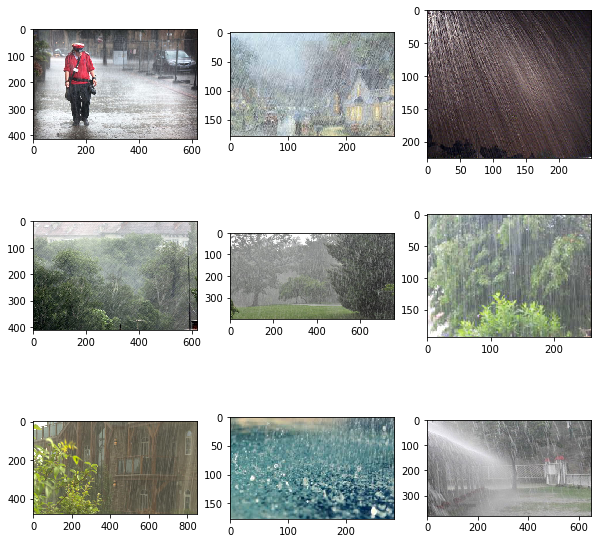

In [83]:
plt.figure(figsize=(10, 10))
for i, path in enumerate(image_paths[:9]):
    img = tf.keras.preprocessing.image.load_img(path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
plt.show()

In [84]:
def serialize_example(image, label, image_shape):
    feature = {
        'image': _bytes_feature(image),
        'label': _int64_feature(label),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
    }
    
    # Create a Features message using tf.train.Example
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [90]:
# Loop over and serialize dataset, then write to file

In [89]:
tfrecord_dir = 'cnn_practice_2_data.tfrecords'

with tf.io.TFRecordWriter(tfrecord_dir) as writer:
    for image_path, label in zip(image_paths, labels):
        
        img = tf.keras.preprocessing.image.load_img(image_path)
        
        # Convert to numpy array
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        # Data augmentation (random_zoom)
        img_array = tf.keras.preprocessing.image.random_zoom(img_array, (0.5, 0.5), row_axis=0, col_axis=0, channel_axis=2)
        
        img_bytes = tf.io.serialize_tensor(img_array)
        image_shape = img_array.shape
        
        example = serialize_example(img_bytes, label, image_shape)
        writer.write(example)

In [91]:
# ------------------- #
# Read from TFRecords #
# ------------------- #

In [101]:
def read_tfrecord(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature((), tf.string),
        'label': tf.io.FixedLenFeature((), tf.int64),
        'height': tf.io.FixedLenFeature((), tf.int64),
        'width': tf.io.FixedLenFeature((), tf.int64),
        'depth': tf.io.FixedLenFeature((), tf.int64),
    }
    
    example = tf.io.parse_single_example(serialized_example, feature_description)
    
    image = tf.io.parse_tensor(example['image'], out_type = float)
    image_shape = [example['height'], example['width'], example['depth']]
    image = tf.reshape(image, image_shape)
    
    return image, example['label']

In [102]:
# ------------------------- #
# Apply function to dataset #
# ------------------------- #

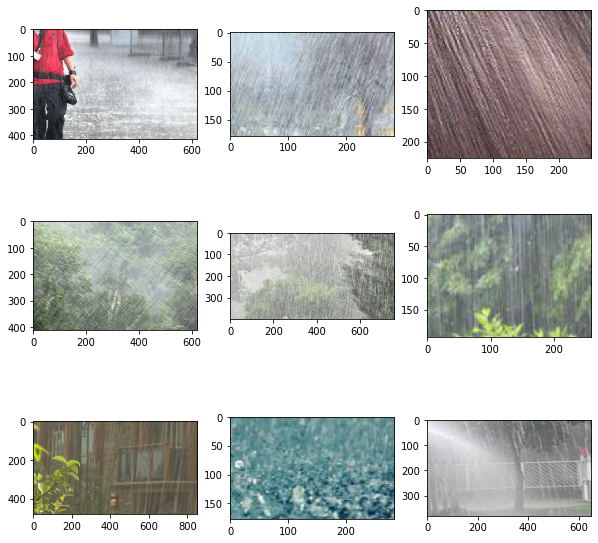

In [106]:
tfrecord_dataset = tf.data.TFRecordDataset(tfrecord_dir)
parsed_dataset = tfrecord_dataset.map(read_tfrecord)

plt.figure(figsize=(10, 10))
for i, data in enumerate(parsed_dataset.take(9)):
    img = tf.keras.preprocessing.image.array_to_img(data[0])
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
plt.show()

In [113]:
for item in parsed_dataset.take(10):
    print(item, '\n')

(<tf.Tensor: id=27234, shape=(413, 620, 3), dtype=float32, numpy=
array([[[151.25 ,  64.875,  95.   ],
        [163.75 ,  89.625, 120.   ],
        [175.625, 114.375, 144.75 ],
        ...,
        [103.125, 108.   , 113.   ],
        [101.25 , 106.25 , 112.25 ],
        [103.75 , 108.75 , 114.75 ]],

       [[153.5  ,  61.   ,  91.75 ],
        [152.5  ,  73.   , 103.25 ],
        [164.75 ,  98.75 , 128.5  ],
        ...,
        [103.   , 108.   , 113.25 ],
        [101.75 , 106.75 , 112.75 ],
        [105.25 , 110.25 , 116.25 ]],

       [[159.25 ,  62.5  ,  92.875],
        [156.75 ,  72.5  , 102.625],
        [164.625,  93.625, 123.375],
        ...,
        [105.25 , 110.625, 115.75 ],
        [105.5  , 110.5  , 116.5  ],
        [108.5  , 113.5  , 119.5  ]],

       ...,

       [[ 38.5  ,  39.5  ,  44.5  ],
        [ 40.5  ,  41.5  ,  46.5  ],
        [ 42.75 ,  43.75 ,  48.75 ],
        ...,
        [187.125, 187.625, 187.375],
        [187.   , 187.   , 187.   ],
        [188

In [165]:
###########
# My Turn #
###########

In [114]:
from __future__ import print_function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAvgPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import model_from_json
from tensorflow.keras import backend as K

In [117]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [123]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [217]:
epochs = 4
batch_size = 128

# Fit the model weights.
model.fit(
    imgs,
    labels,
    epochs=epochs,
    verbose=1
)
          

ValueError: ('Error when checking model target: expected no data, but got:', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1]))